# NPPC historical phenotypic barley data analysis

## Load packages, custom functions and data

In [1]:
library(readxl)
library(tidyverse)
library(multtest)
library(asreml)

source("../custom_functions.r")

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: BiocGenerics




Attaching package: ‘BiocGenerics’




The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union




The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union




The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs




The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min




Loading required package: Biobase



Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.




Loading required package: Matrix




Attaching package: ‘Matrix’




The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




Online License checked out Wed May  8 00:59:07 2024


Loading ASReml-R version 4.2




In [2]:
data_total_winter <- preprocess("Historic_Barley_W_NPPC.xlsx")
write_csv(data_total_winter, "NPPC_winter_barley.csv")
genotypes_w <- distinct(data_total_winter["accenumb"]) |> rename("genotype" = "accenumb")
cat("Winter Barley:\n", nrow(data_total_winter), "observations\n", nrow(genotypes_w), "genotypes\n", nrow(distinct(data_total_winter["campaign"])), "campaigns\n\n")
summary(data_total_winter[c("days_to_heading", "plant_height", "thousand_kernel_weight")])

Winter Barley:
 1452 observations
 520 genotypes
 22 campaigns



 days_to_heading  plant_height    thousand_kernel_weight
 Min.   : 75.0   Min.   : 17.10   Min.   :29.55         
 1st Qu.:217.0   1st Qu.: 86.88   1st Qu.:43.60         
 Median :222.0   Median : 93.60   Median :48.00         
 Mean   :221.7   Mean   : 91.85   Mean   :48.60         
 3rd Qu.:227.0   3rd Qu.: 99.00   3rd Qu.:53.90         
 Max.   :237.0   Max.   :131.20   Max.   :65.60         
 NA's   :437     NA's   :60       NA's   :105           

In [3]:
data_total_spring <- preprocess("Historic_Barley_S_NPPC.xlsx")
write_csv(data_total_spring, "NPPC_spring_barley.csv")
genotypes_s <- distinct(data_total_spring["accenumb"]) |> rename("genotype" = "accenumb")
cat("Spring Barley:\n", nrow(data_total_spring), "observations\n", nrow(genotypes_s), "genotypes\n", nrow(distinct(data_total_spring["campaign"])), "campaigns\n\n")
summary(data_total_spring[c("days_to_heading", "plant_height", "thousand_kernel_weight")])

Spring Barley:
 2254 observations
 1053 genotypes
 33 campaigns



 days_to_heading   plant_height    thousand_kernel_weight
 Min.   : 38.00   Min.   :  6.48   Min.   : 3.60         
 1st Qu.: 70.00   1st Qu.: 71.33   1st Qu.:40.00         
 Median : 78.00   Median : 77.42   Median :44.00         
 Mean   : 77.41   Mean   : 78.86   Mean   :43.09         
 3rd Qu.: 86.00   3rd Qu.: 86.00   3rd Qu.:48.23         
 Max.   :104.00   Max.   :120.33   Max.   :66.00         
 NA's   :1384     NA's   :242      NA's   :501           

## Subset data, remove missing values and singletons, make factors

In [4]:
cat("Winter:\n")
data_sub_WB_HT <- data_total_winter |> make_data_sub("days_to_heading")
data_sub_WB_PH <- data_total_winter |> make_data_sub("plant_height")
data_sub_WB_TKW <- data_total_winter |> make_data_sub("thousand_kernel_weight")

Winter:


568 days_to_heading rows kept


1041 plant_height rows kept


1010 thousand_kernel_weight rows kept


In [5]:
cat("Spring:\n")
data_sub_SB_HT <- data_total_spring |> make_data_sub("days_to_heading")
data_sub_SB_PH <- data_total_spring |> make_data_sub("plant_height")
data_sub_SB_TKW <- data_total_spring |> make_data_sub("thousand_kernel_weight")

Spring:


523 days_to_heading rows kept


1409 plant_height rows kept


1293 thousand_kernel_weight rows kept


## Visualise trait values 

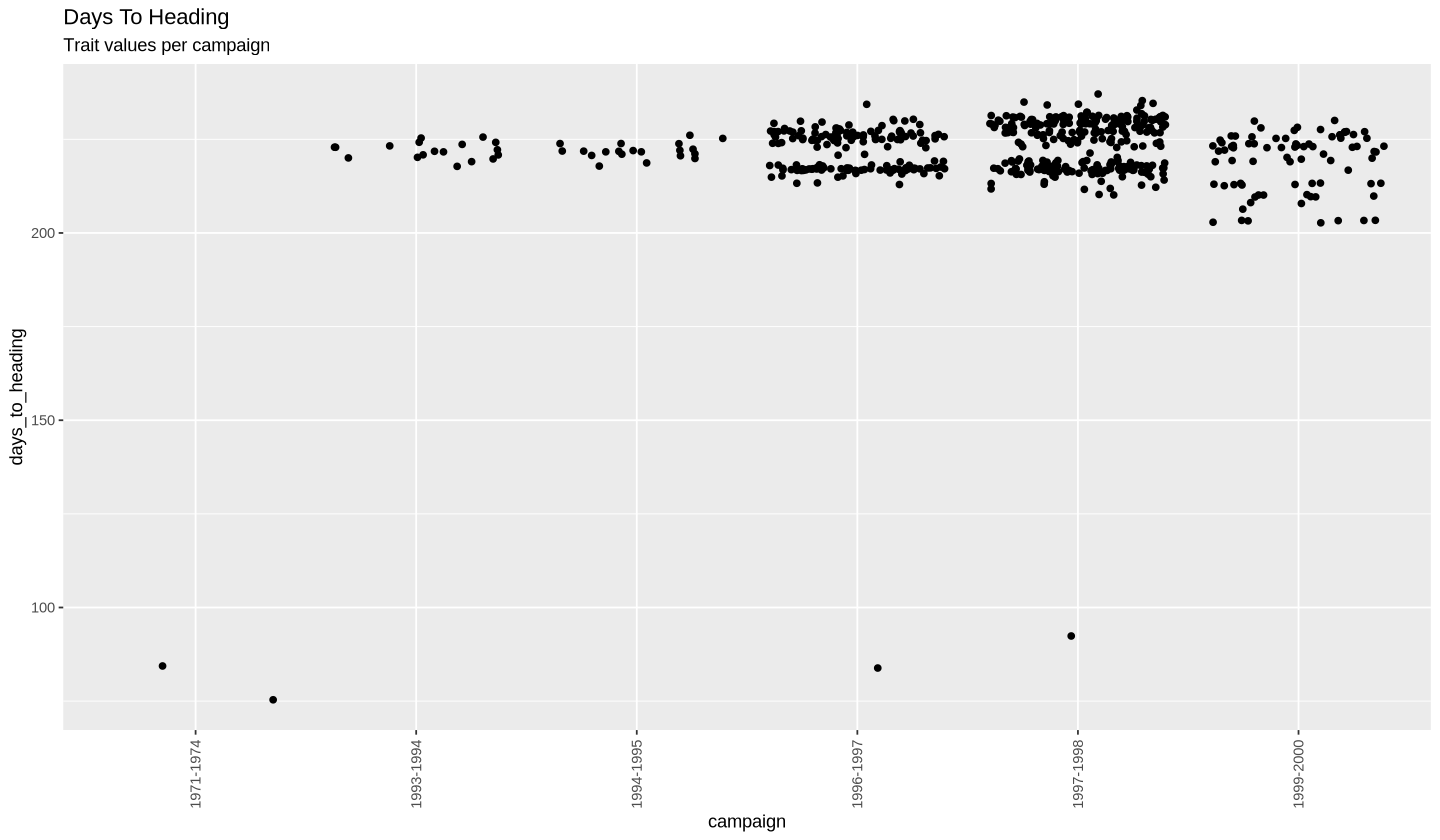

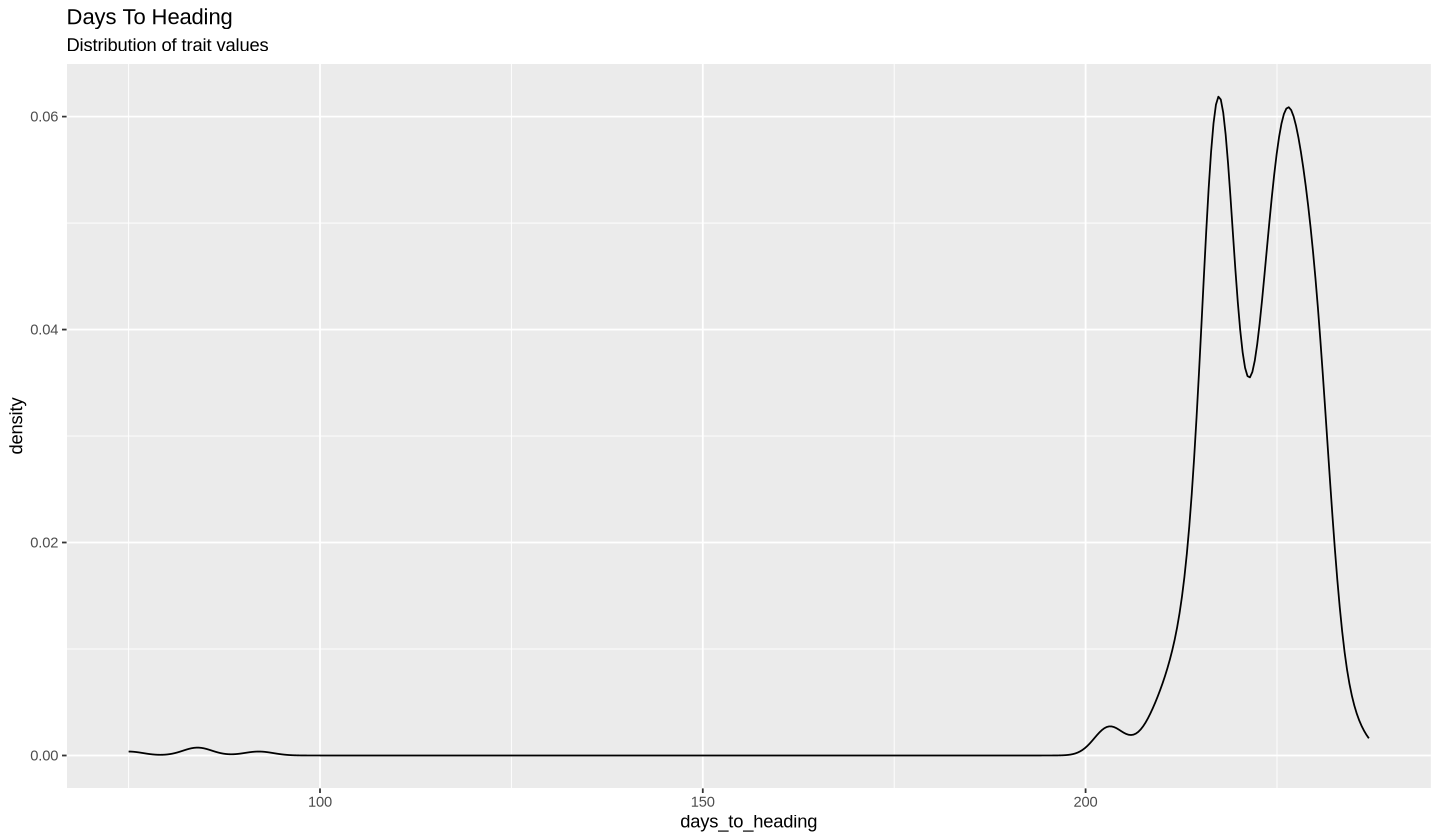

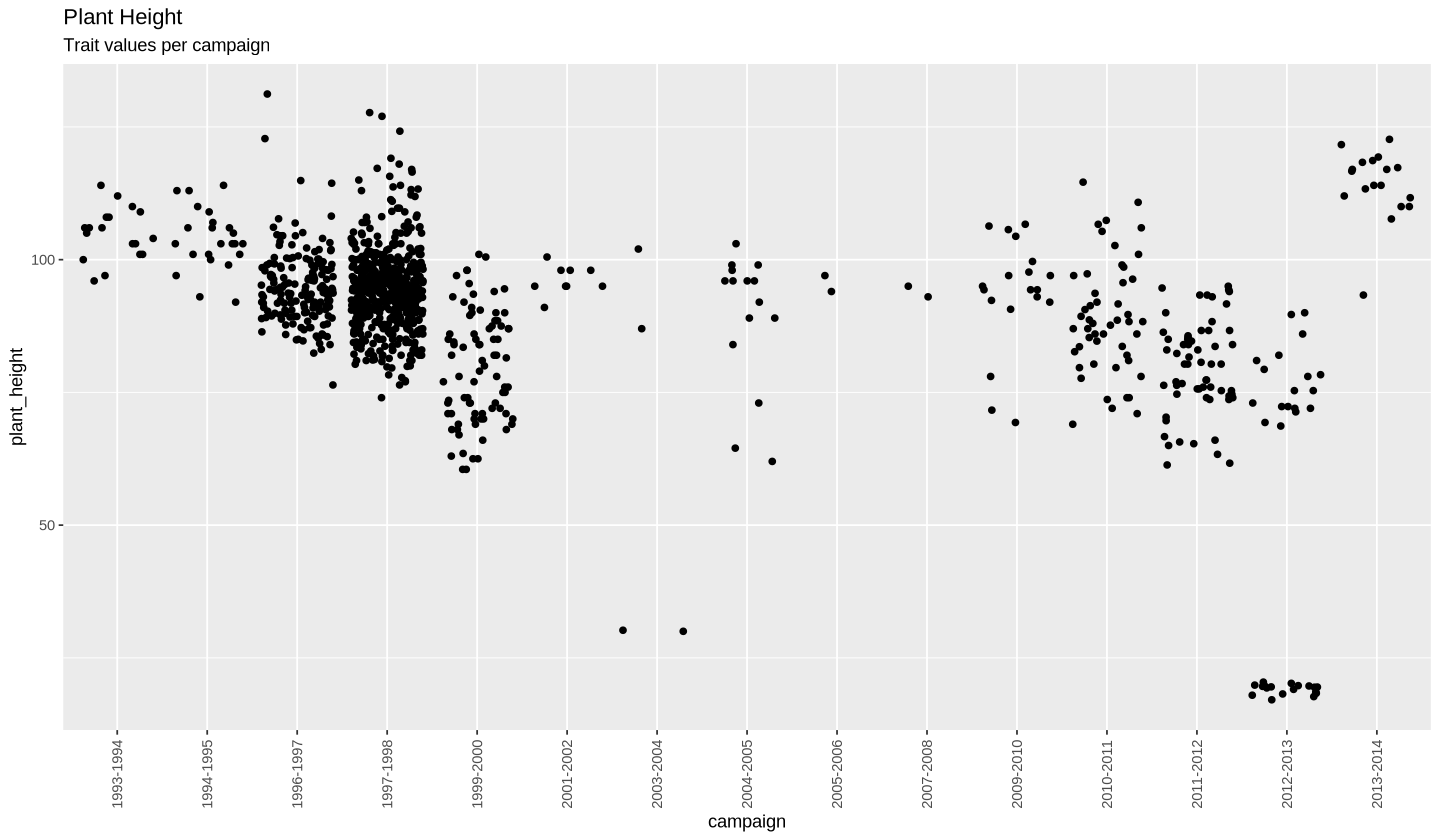

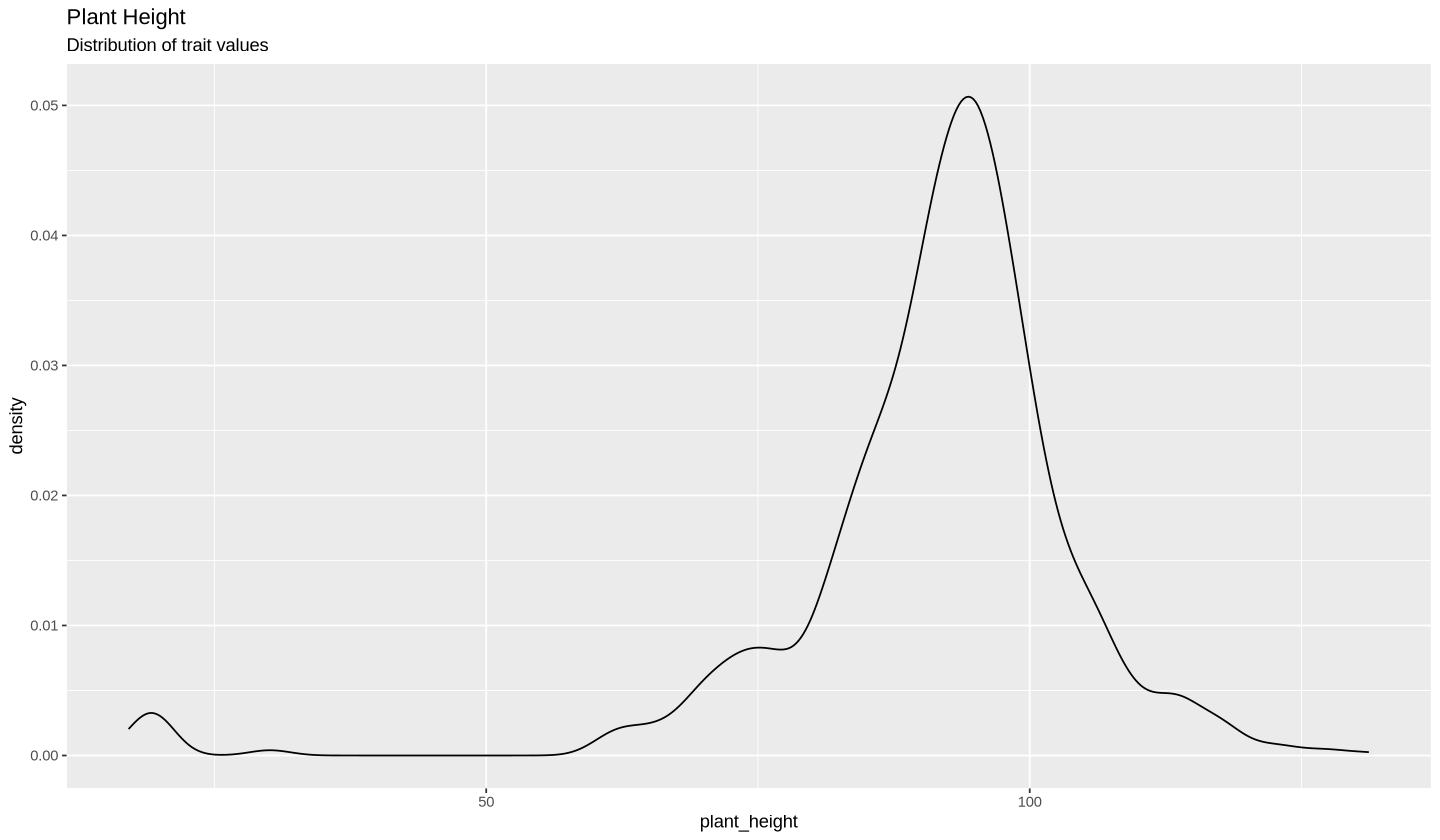

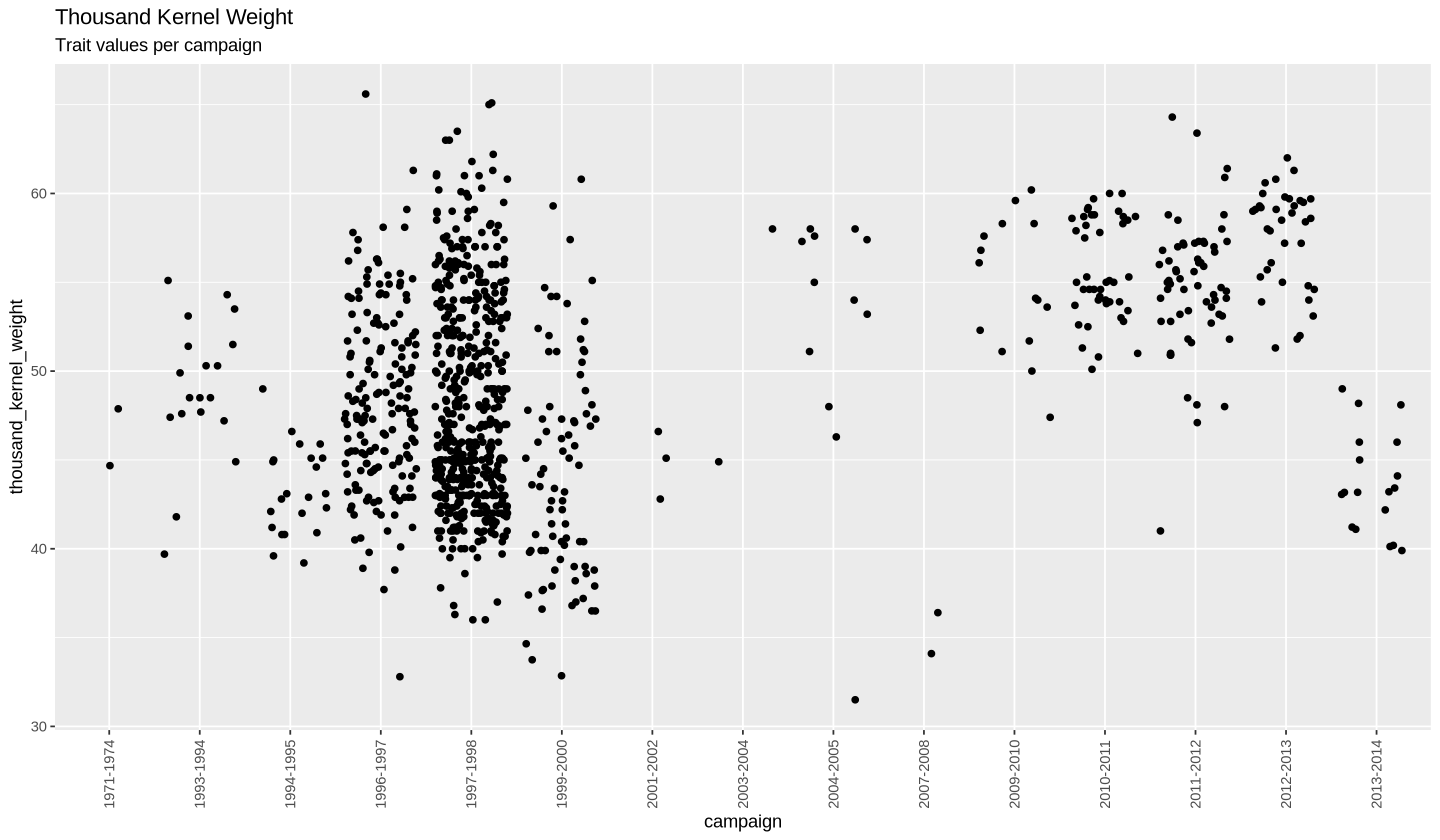

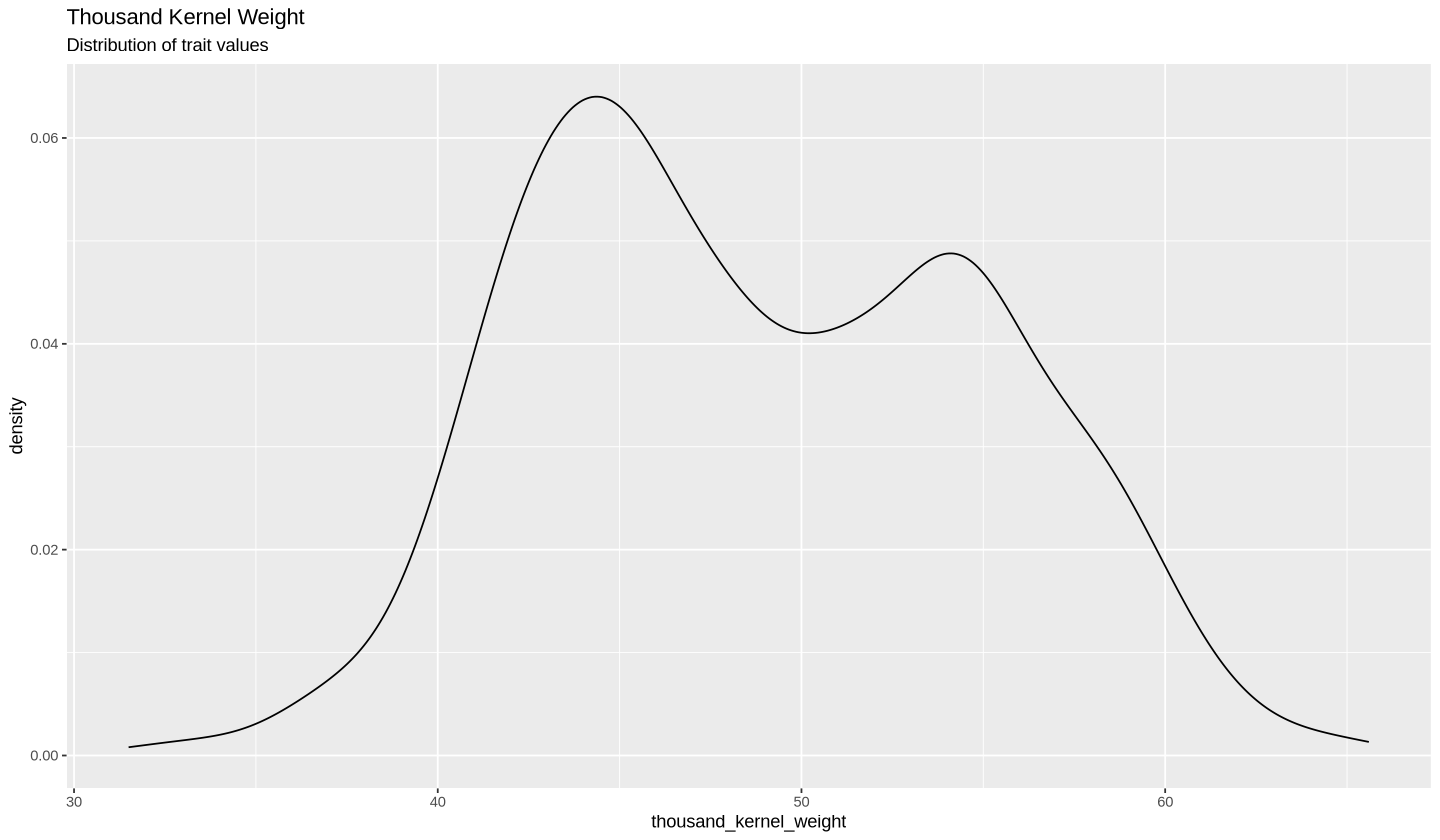

In [6]:
options(repr.plot.width=12, repr.plot.height=7)
data_sub_WB_HT |> visualise_trait(geom_density())
data_sub_WB_PH |> visualise_trait(geom_density())
data_sub_WB_TKW |> visualise_trait(geom_density())

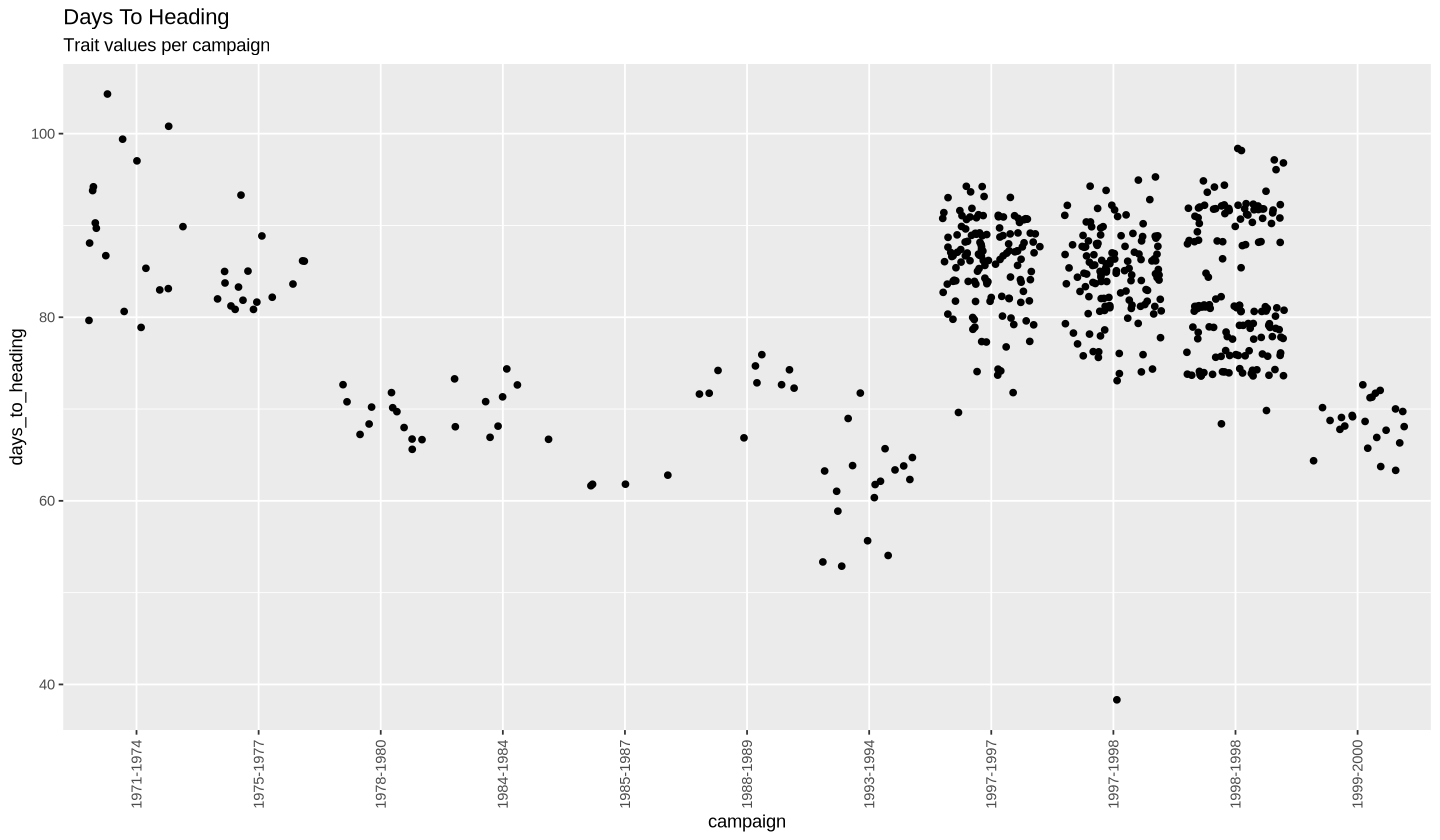

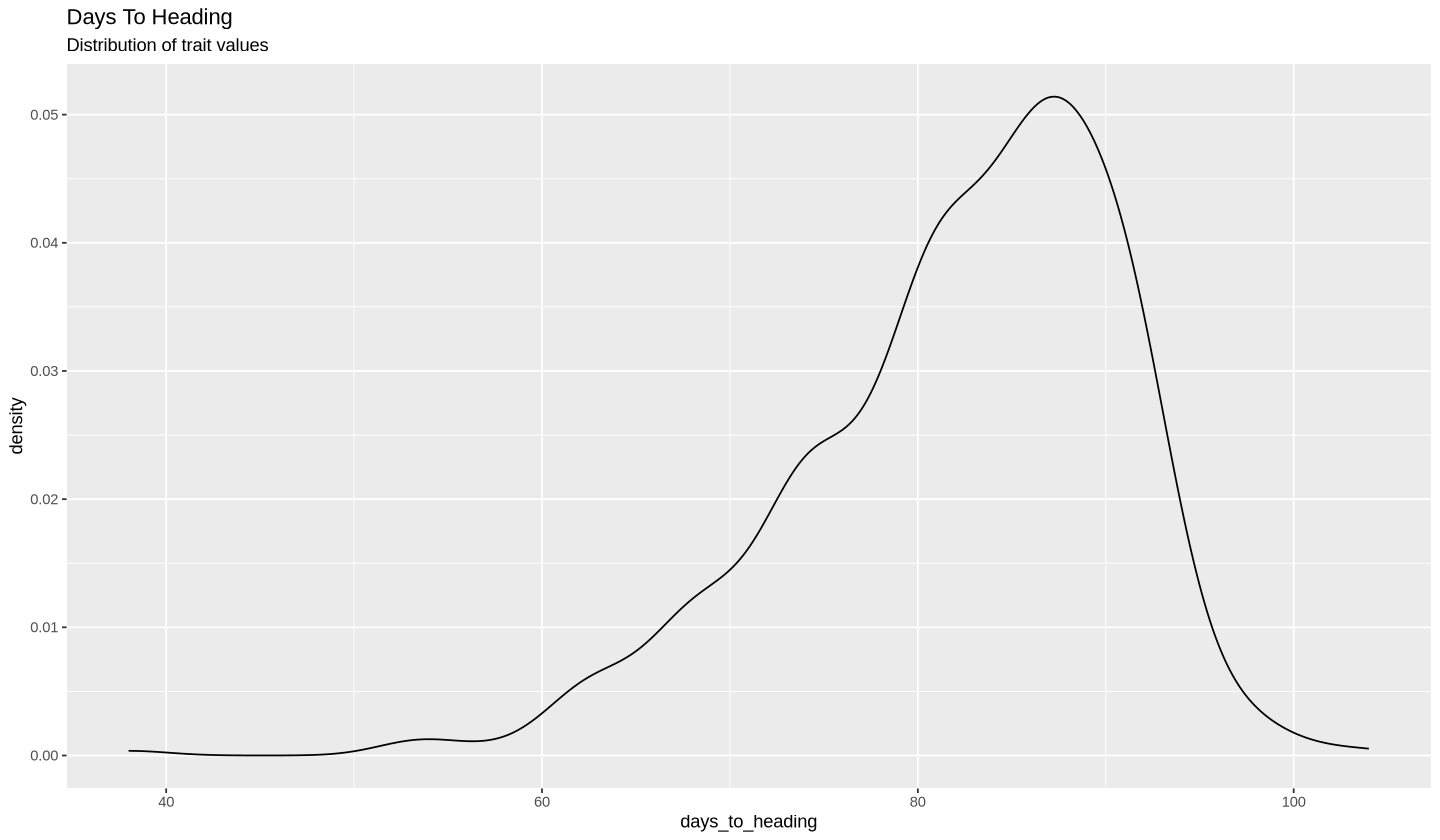

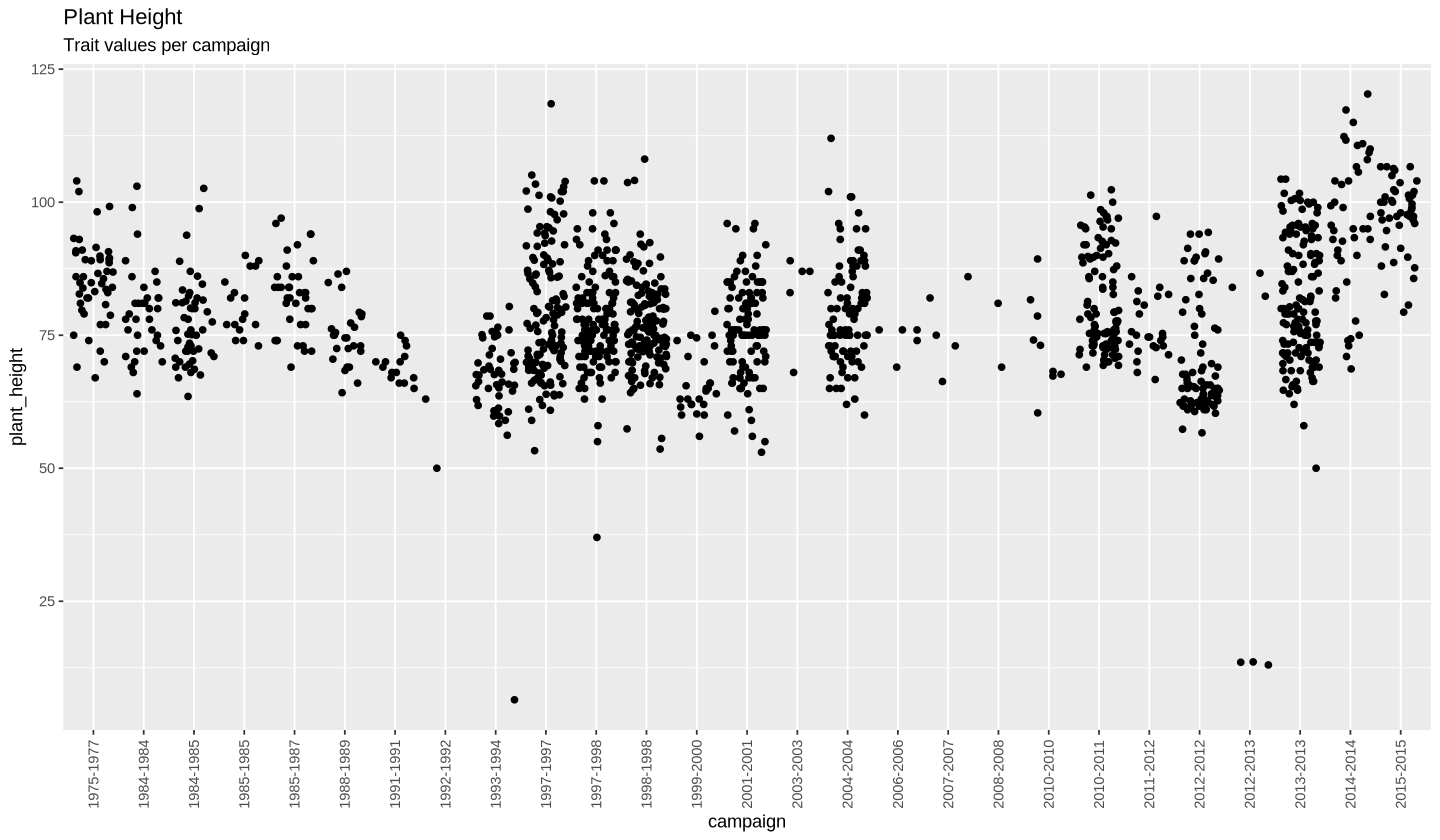

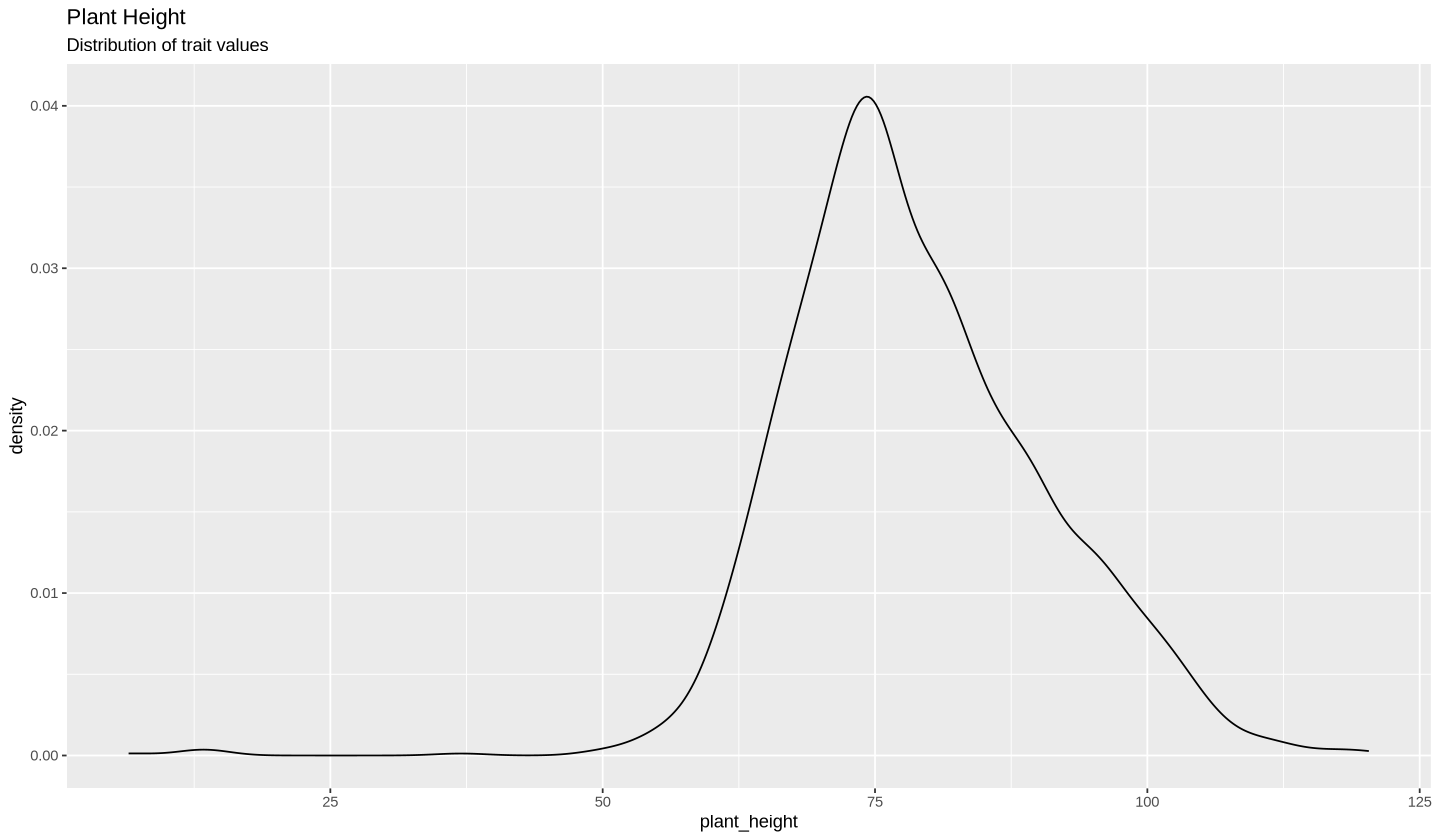

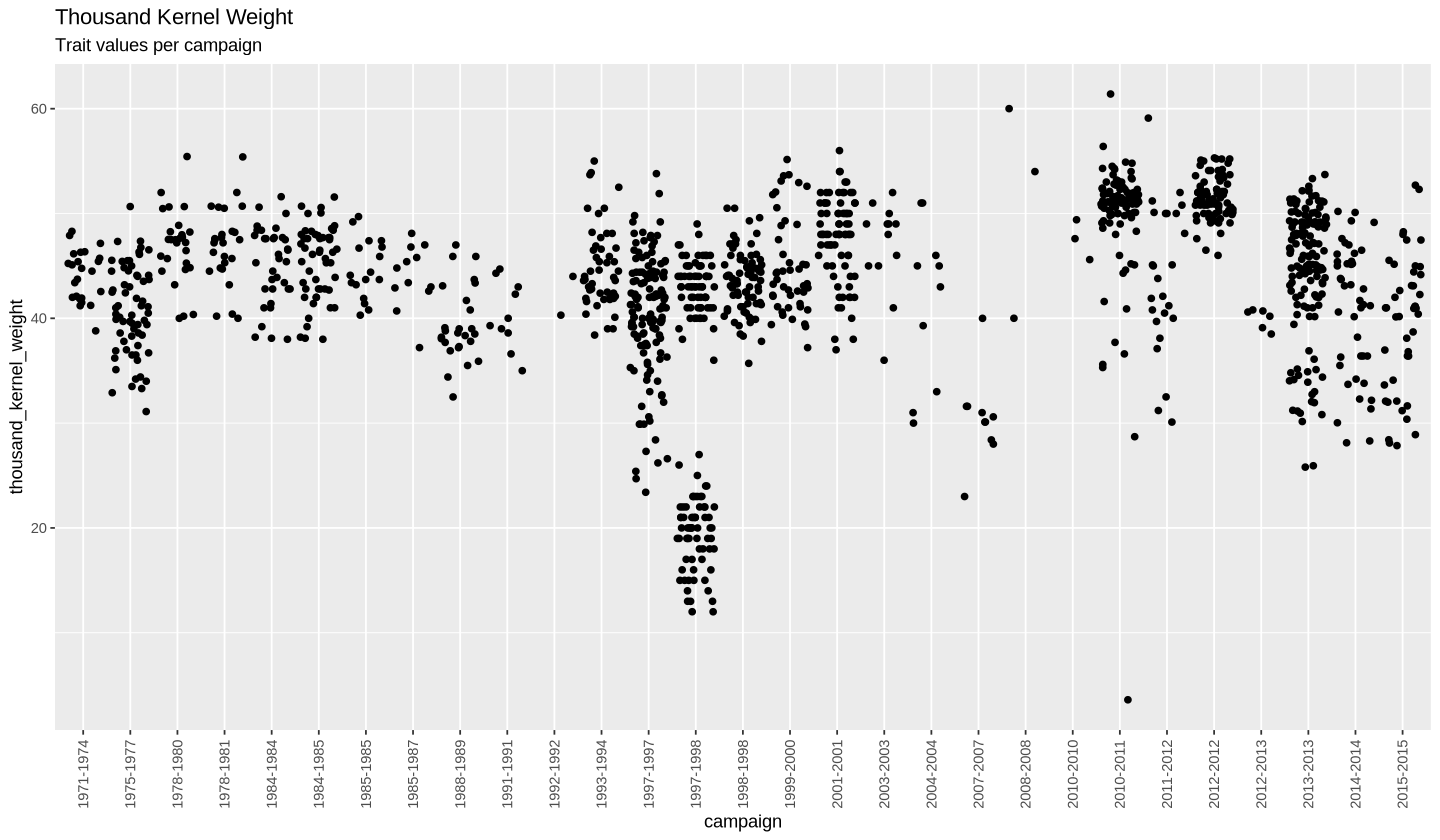

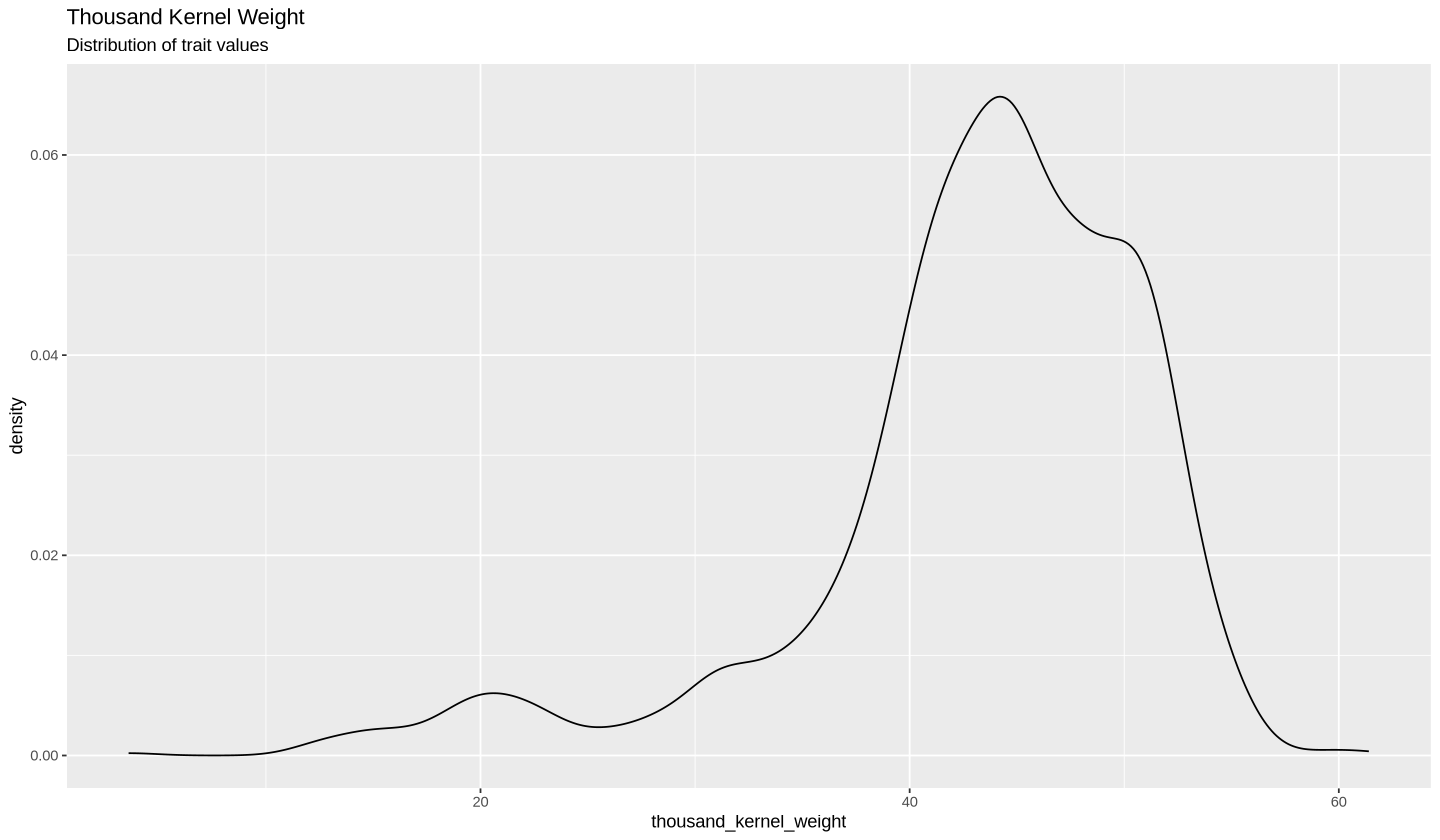

In [7]:
data_sub_SB_HT |> visualise_trait(geom_density())
data_sub_SB_PH |> visualise_trait(geom_density())
data_sub_SB_TKW |> visualise_trait(geom_density())

## Extract and format the campaign effects

In [8]:
asreml_campaign_WB_HT <- asreml(fixed = days_to_heading ~campaign, random = ~accenumb, 
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign),
                             data = data_sub_WB_HT)

In [9]:
asreml_campaign_WB_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_WB_PH)

In [10]:
asreml_campaign_WB_TKW <- asreml(fixed = thousand_kernel_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_WB_TKW)

In [11]:
asreml_campaign_SB_HT <- asreml(fixed = days_to_heading ~campaign, random = ~accenumb, 
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign),
                              data = data_sub_SB_HT)

Warning message in asreml(fixed = days_to_heading ~ campaign, random = ~accenumb, :
“Log-likelihood not converged”


Warning message in asreml(fixed = days_to_heading ~ campaign, random = ~accenumb, :
“Some components changed by more than 1% on the last iteration”


In [12]:
asreml_campaign_SB_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_SB_PH)

In [13]:
asreml_campaign_SB_TKW <- asreml(fixed = thousand_kernel_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_SB_TKW)

In [14]:
campaign_effect_WB_HT <- get_campaign_effect(asreml_campaign_WB_HT)
campaign_effect_WB_PH <- get_campaign_effect(asreml_campaign_WB_PH)
campaign_effect_WB_TKW <- get_campaign_effect(asreml_campaign_WB_TKW)

In [15]:
campaign_effect_SB_HT <- get_campaign_effect(asreml_campaign_SB_HT)
campaign_effect_SB_PH <- get_campaign_effect(asreml_campaign_SB_PH)
campaign_effect_SB_TKW <- get_campaign_effect(asreml_campaign_SB_TKW)

## Extract heterogeneous error variances

In [16]:
error_var_WB_HT <- get_error_var(asreml_campaign_WB_HT)
error_var_WB_PH <- get_error_var(asreml_campaign_WB_PH)
error_var_WB_TKW <- get_error_var(asreml_campaign_WB_TKW)

In [17]:
error_var_SB_HT <- get_error_var(asreml_campaign_SB_HT)
error_var_SB_PH <- get_error_var(asreml_campaign_SB_PH)
error_var_SB_TKW <- get_error_var(asreml_campaign_SB_TKW)

## Calculate and standardize the coefficient of variation (CV)

In [18]:
CV_df_WB_HT <- make_CV_df(campaign_effect_WB_HT, error_var_WB_HT)
CV_df_WB_PH <- make_CV_df(campaign_effect_WB_PH, error_var_WB_PH)
CV_df_WB_TKW <- make_CV_df(campaign_effect_WB_TKW, error_var_WB_TKW)

In [19]:
CV_df_SB_HT <- make_CV_df(campaign_effect_SB_HT, error_var_SB_HT)
CV_df_SB_PH <- make_CV_df(campaign_effect_SB_PH, error_var_SB_PH)
CV_df_SB_TKW <- make_CV_df(campaign_effect_SB_TKW, error_var_SB_TKW)

## Remove outlier campaigns

In [20]:
data_corrected_WB_HT_I <- data_sub_WB_HT |> correct_I(CV_df_WB_HT)
data_corrected_WB_PH_I <- data_sub_WB_PH |> correct_I(CV_df_WB_PH)
data_corrected_WB_TKW_I <- data_sub_WB_TKW |> correct_I(CV_df_WB_TKW)

0 outlier campaign(s) detected for trait days_to_heading


0 outlier campaign(s) detected for trait plant_height


0 outlier campaign(s) detected for trait thousand_kernel_weight


In [21]:
data_corrected_SB_HT_I <- data_sub_SB_HT |> correct_I(CV_df_SB_HT)
data_corrected_SB_PH_I <- data_sub_SB_PH |> correct_I(CV_df_SB_PH)
data_corrected_SB_TKW_I <- data_sub_SB_TKW |> correct_I(CV_df_SB_TKW)

0 outlier campaign(s) detected for trait days_to_heading


1 outlier campaign(s) detected for trait plant_height: 2012-2013 


1 outlier campaign(s) detected for trait thousand_kernel_weight: 2008-2008 


## Residuals

In [22]:
asreml_res_WB_HT <- asreml(fixed = days_to_heading ~ accenumb, random = ~ campaign,
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_WB_HT_I)

Warning message in asreml(fixed = days_to_heading ~ accenumb, random = ~campaign, :
“Log-likelihood not converged”


Warning message in asreml(fixed = days_to_heading ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration”


In [23]:
asreml_res_WB_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_WB_PH_I)

Warning message in asreml(fixed = plant_height ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Log-likelihood not converged”


In [24]:
asreml_res_WB_TKW <- asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_WB_TKW_I)

In [25]:
asreml_res_SB_HT <- asreml(fixed = days_to_heading ~ accenumb, random = ~ campaign,
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_SB_HT_I)

In [26]:
asreml_res_SB_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_SB_PH_I)

In [27]:
asreml_res_SB_TKW <- asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_SB_TKW_I)

15 outlier value(s) detected for trait Days To Heading 


108 outlier value(s) detected for trait Plant Height 


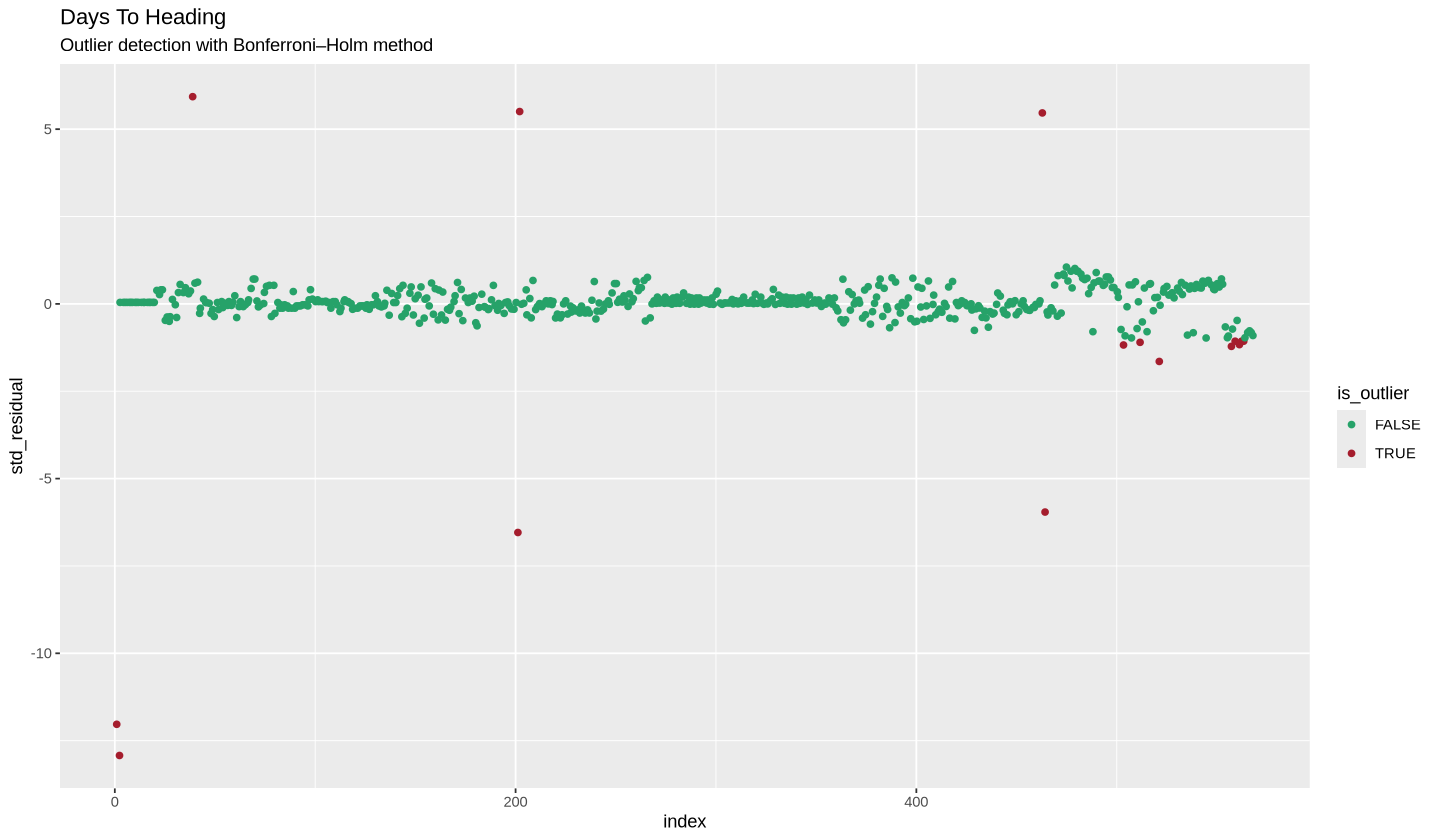

69 outlier value(s) detected for trait Thousand Kernel Weight 


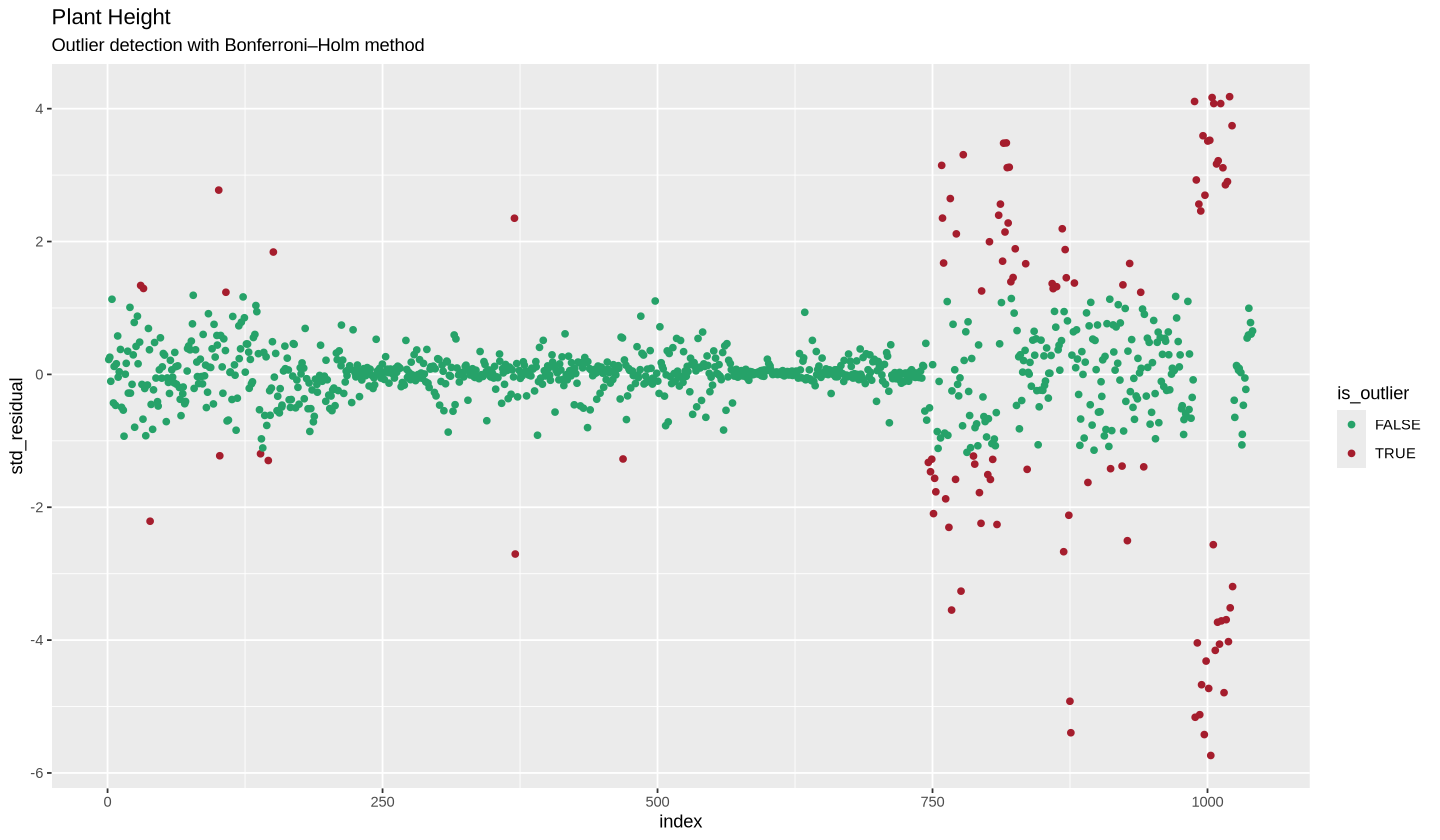

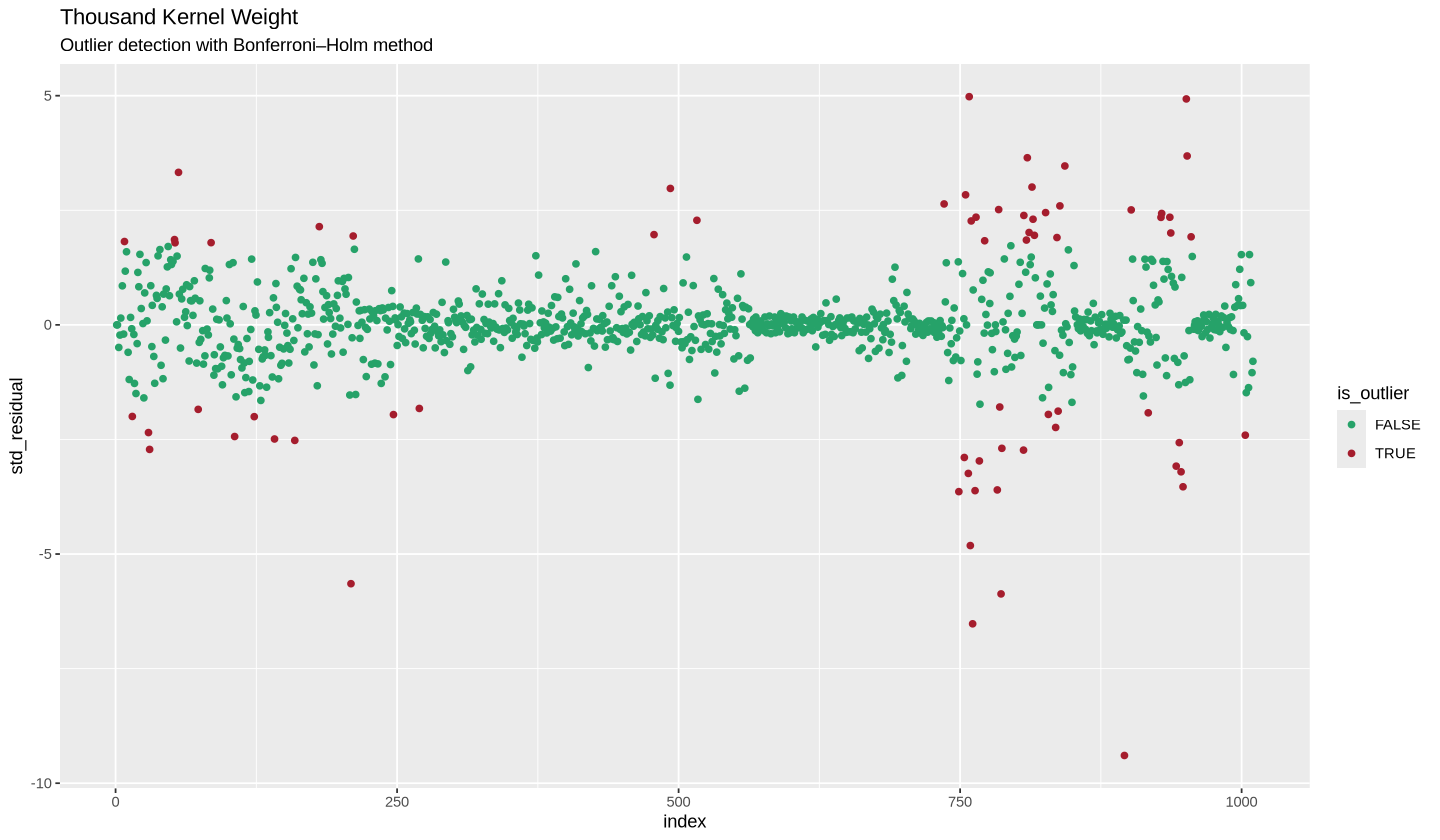

In [28]:
result_BH_WB_HT <- make_BH_multtest(asreml_res_WB_HT)
result_BH_WB_PH <- make_BH_multtest(asreml_res_WB_PH)
result_BH_WB_TKW <- make_BH_multtest(asreml_res_WB_TKW)

1 outlier value(s) detected for trait Days To Heading 


22 outlier value(s) detected for trait Plant Height 


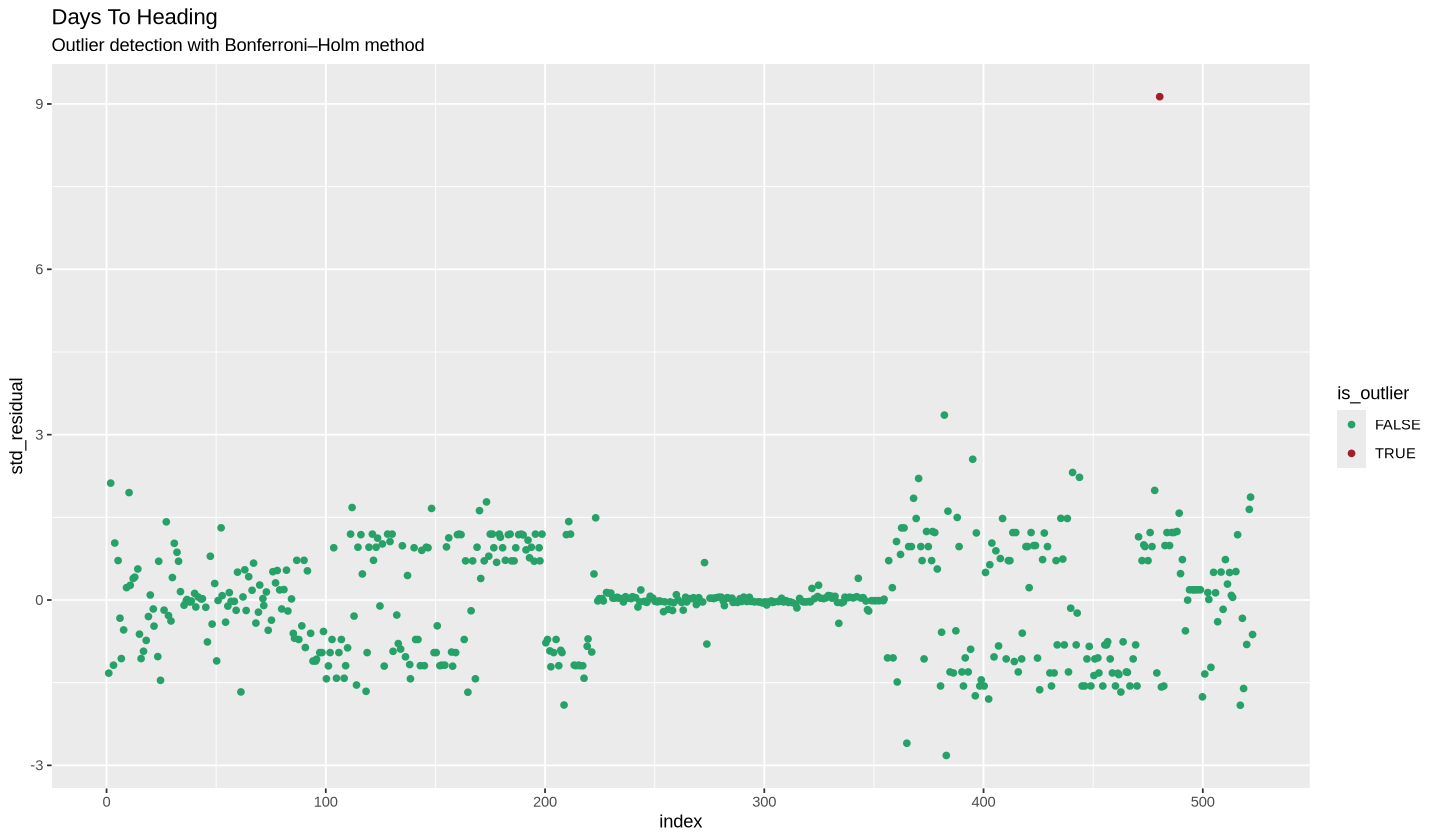

125 outlier value(s) detected for trait Thousand Kernel Weight 


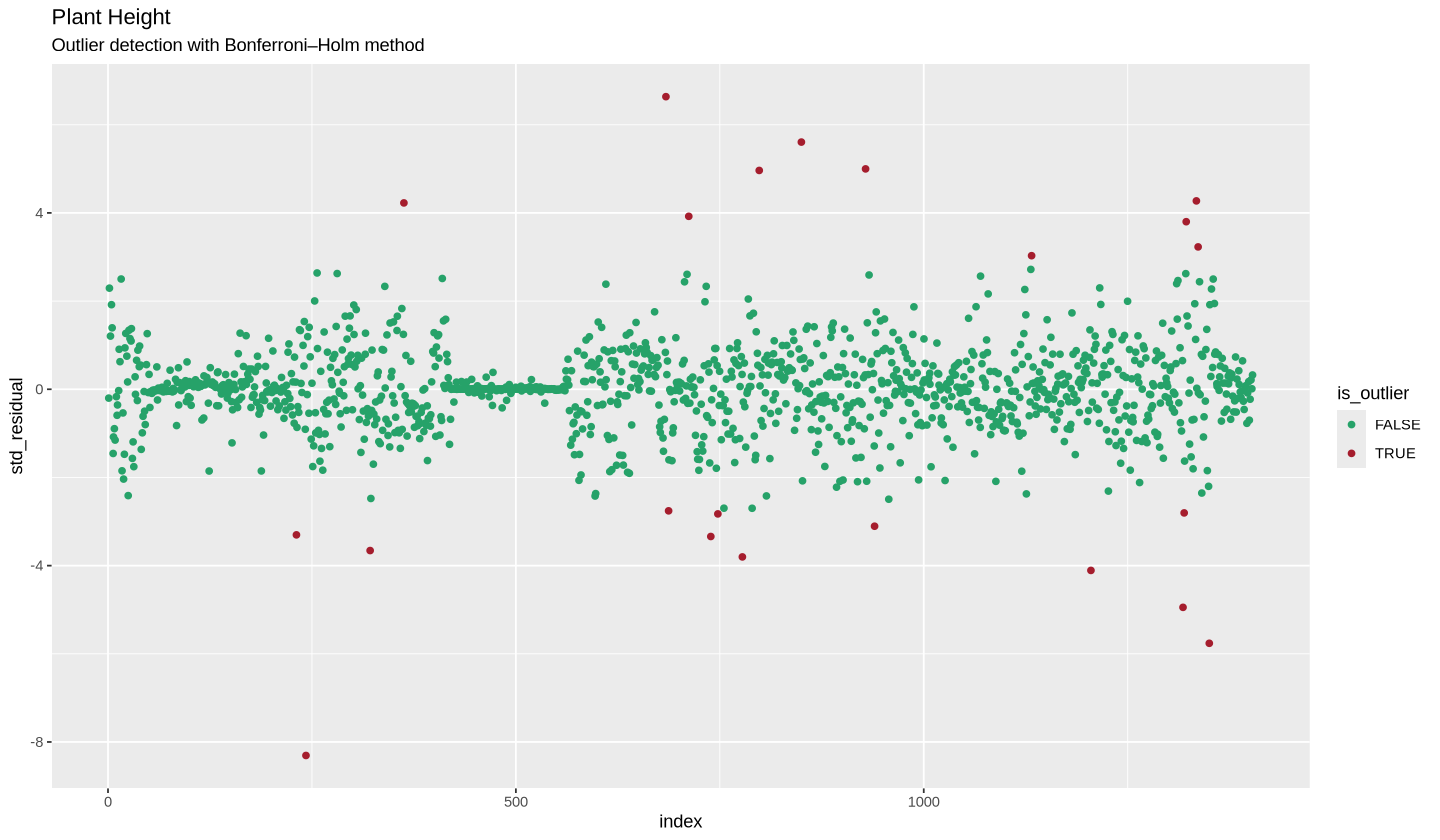

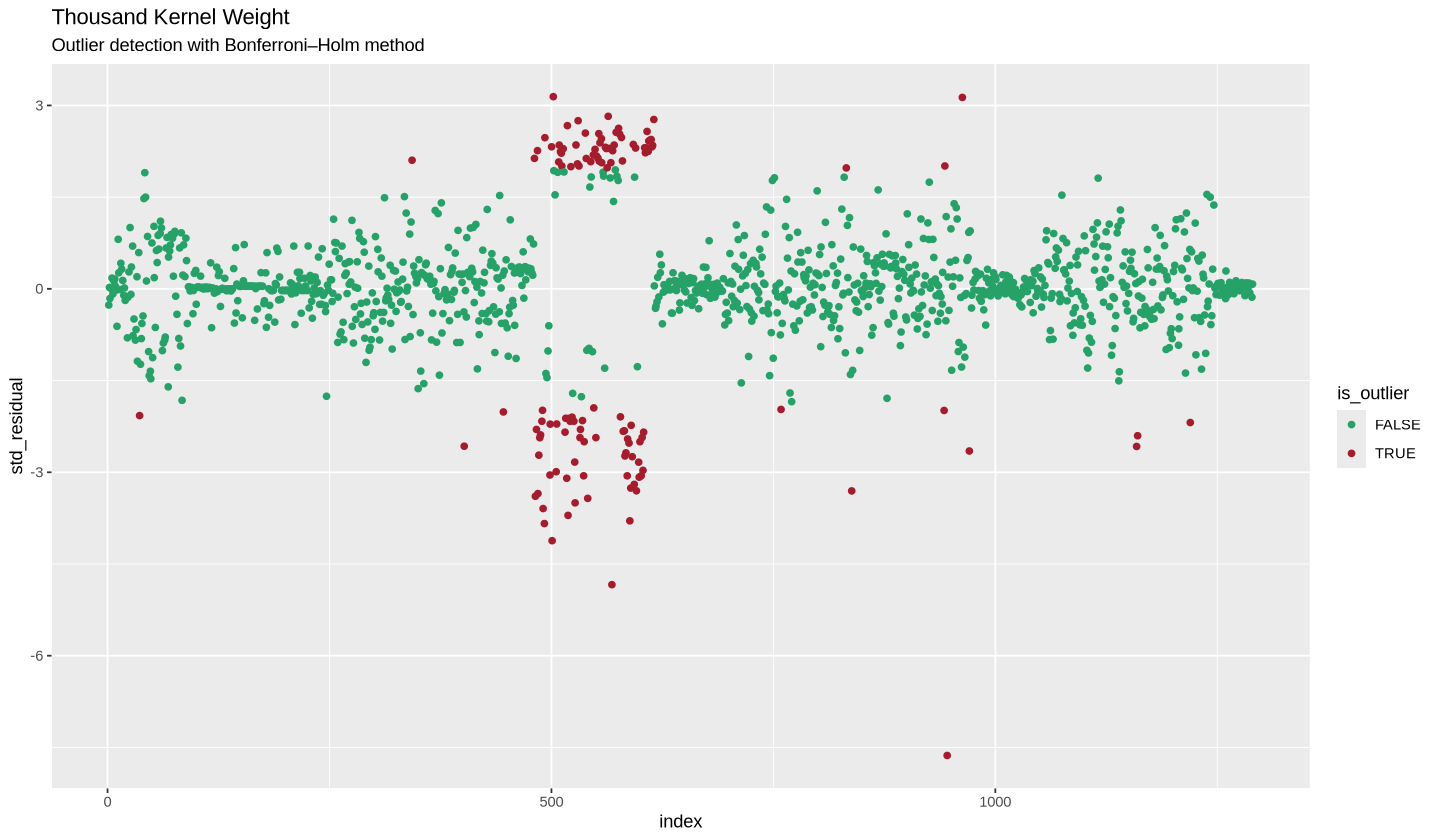

In [29]:
result_BH_SB_HT <- make_BH_multtest(asreml_res_SB_HT)
result_BH_SB_PH <- make_BH_multtest(asreml_res_SB_PH)
result_BH_SB_TKW <- make_BH_multtest(asreml_res_SB_TKW)

In [30]:
data_corrected_WB_HT_II <- data_corrected_WB_HT_I |> correct_II(result_BH_WB_HT)
data_corrected_WB_PH_II <- data_corrected_WB_PH_I |> correct_II(result_BH_WB_PH)
data_corrected_WB_TKW_II <- data_corrected_WB_TKW_I |> correct_II(result_BH_WB_TKW)

In [31]:
data_corrected_SB_HT_II <- data_corrected_SB_HT_I |> correct_II(result_BH_SB_HT)
data_corrected_SB_PH_II <- data_corrected_SB_PH_I |> correct_II(result_BH_SB_PH)
data_corrected_SB_TKW_II <- data_corrected_SB_TKW_I |> correct_II(result_BH_SB_TKW)

## Calculate heritability

In [32]:
asreml_res_h_WB_HT <- asreml(days_to_heading ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_WB_HT_II)

In [33]:
asreml_res_h_WB_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_WB_PH_II)

In [34]:
asreml_res_h_WB_TKW <- asreml(thousand_kernel_weight ~1, random = ~accenumb + campaign, 
                    na.action = na.method(x="omit", y="omit"),
                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_WB_TKW_II)

Warning message in asreml(thousand_kernel_weight ~ 1, random = ~accenumb + campaign, :
“Warning : Log-likelihood decreased to -1850.56; trying with reduced updates 0.542024”


Warning message in asreml(thousand_kernel_weight ~ 1, random = ~accenumb + campaign, :
“Log-likelihood not converged”


In [35]:
asreml_res_h_SB_HT <- asreml(days_to_heading ~1, random = ~accenumb + campaign, 
                    na.action = na.method(x="omit", y="omit"), 
                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_SB_HT_II)

In [36]:
asreml_res_h_SB_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_SB_PH_II)

In [37]:
asreml_res_h_SB_TKW <- asreml(thousand_kernel_weight ~1, random = ~accenumb + campaign, 
                     na.action = na.method(x="omit", y="omit"),
                     residual = ~dsum( ~id(units) | campaign), data = data_corrected_SB_TKW_II)

In [38]:
quality_WB_HT <- get_quality(data_sub_WB_HT, asreml_res_h_WB_HT)
quality_WB_PH <- get_quality(data_sub_WB_PH, asreml_res_h_WB_PH)
quality_WB_TKW <- get_quality(data_sub_WB_TKW, asreml_res_h_WB_TKW)
quality_WB_all <- bind_rows(quality_WB_HT, quality_WB_PH, quality_WB_TKW) |> mutate(across(-1, \(x) round(x, 3)))
write_csv(quality_WB_all,"NPPC_winter_barley_data_quality.csv")

days_to_heading heritability: 76.2 %


plant_height heritability: 91 %


thousand_kernel_weight heritability: 97.5 %


In [39]:
quality_SB_HT <- get_quality(data_sub_SB_HT, asreml_res_h_SB_HT)
quality_SB_PH <- get_quality(data_sub_SB_PH, asreml_res_h_SB_PH)
quality_SB_TKW <- get_quality(data_sub_SB_TKW, asreml_res_h_SB_TKW)
quality_SB_all <- bind_rows(quality_SB_HT, quality_SB_PH, quality_SB_TKW) |> mutate(across(-1, \(x) round(x, 3)))
write_csv(quality_SB_all,"NPPC_spring_barley_data_quality.csv")

days_to_heading heritability: 81.9 %


plant_height heritability: 91.8 %


thousand_kernel_weight heritability: 87.4 %


## Run linear mixed model with outlier corrected data

In [40]:
asreml_data_WB_HT <- asreml(days_to_heading ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_WB_HT_II)

In [41]:
asreml_data_WB_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_WB_PH_II)

Warning message in asreml(plant_height ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Log-likelihood not converged”


Warning message in asreml(plant_height ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration”


In [42]:
asreml_data_WB_TKW <- asreml(thousand_kernel_weight ~accenumb, random = ~campaign, 
                           na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                           data = data_corrected_WB_TKW_II)

In [43]:
asreml_data_SB_HT <- asreml(days_to_heading ~accenumb, random = ~campaign, 
                          na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                          data = data_corrected_SB_HT_II)

In [44]:
asreml_data_SB_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_SB_PH_II)

In [45]:
asreml_data_SB_TKW <- asreml(thousand_kernel_weight ~accenumb, random = ~campaign, 
                           na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                           data = data_corrected_SB_TKW_II)

## Extract BLUEs and create output file

In [46]:
BLUEs_WB_HT <- get_BLUEs(asreml_data_WB_HT)
BLUEs_WB_PH <- get_BLUEs(asreml_data_WB_PH)
BLUEs_WB_TKW <- get_BLUEs(asreml_data_WB_TKW)

BLUE_WB_all <- genotypes_w |> 
                        left_join(BLUEs_WB_HT, by="genotype") |> 
                        left_join(BLUEs_WB_PH, by="genotype") |> 
                        left_join(BLUEs_WB_TKW, by="genotype") |> 
                        arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_WB_all,"NPPC_winter_barley_BLUE_values.csv")
summary(BLUE_WB_all)

   genotype         days_to_heading_BLUE plant_height_BLUE
 Length:520         Min.   :212.6        Min.   : 30.10   
 Class :character   1st Qu.:218.1        1st Qu.: 92.59   
 Mode  :character   Median :223.7        Median : 96.90   
                    Mean   :223.3        Mean   : 96.56   
                    3rd Qu.:227.9        3rd Qu.:101.28   
                    Max.   :234.8        Max.   :130.01   
                    NA's   :363          NA's   :272      
 thousand_kernel_weight_BLUE
 Min.   :38.41              
 1st Qu.:45.72              
 Median :48.44              
 Mean   :49.91              
 3rd Qu.:53.81              
 Max.   :67.31              
 NA's   :277                

In [47]:
BLUEs_SB_HT <- get_BLUEs(asreml_data_SB_HT)
BLUEs_SB_PH <- get_BLUEs(asreml_data_SB_PH)
BLUEs_SB_TKW <- get_BLUEs(asreml_data_SB_TKW)


BLUE_SB_all <- genotypes_s |> 
                        left_join(BLUEs_SB_HT, by="genotype") |> 
                        left_join(BLUEs_SB_PH, by="genotype") |> 
                        left_join(BLUEs_SB_TKW, by="genotype") |> 
                        arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_SB_all,"NPPC_spring_barley_BLUE_values.csv")
summary(BLUE_SB_all)

   genotype         days_to_heading_BLUE plant_height_BLUE
 Length:1053        Min.   :61.82        Min.   : 51.05   
 Class :character   1st Qu.:70.73        1st Qu.: 73.72   
 Mode  :character   Median :73.91        Median : 79.22   
                    Mean   :73.87        Mean   : 79.69   
                    3rd Qu.:76.78        3rd Qu.: 84.73   
                    Max.   :84.02        Max.   :106.57   
                    NA's   :892          NA's   :705      
 thousand_kernel_weight_BLUE
 Min.   :26.23              
 1st Qu.:41.33              
 Median :44.45              
 Mean   :43.79              
 3rd Qu.:46.76              
 Max.   :55.74              
 NA's   :749                

In [48]:
library(rmarkdown)
convert_ipynb("NPPC_historic_barley_data_analysis.ipynb")

In [49]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Fedora Linux 40.20240507.0 (Silverblue)

Matrix products: default
BLAS/LAPACK: /var/home/erwan/.conda/envs/R/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Europe/Paris
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rmarkdown_2.26      asreml_4.2.0.267    Matrix_1.6-5       
 [4] multtest_2.58.0     Biobase_2.62.0      BiocGenerics_0.48.1
 [7] lubridate_1.9.3     forcats_1.0.0       stringr_1.5.1      
[10] dplyr_1.1.4         purrr_1.0.2         readr_2.1.5        
[13] tid